In [165]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel

# Sklearn ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, get_scorer_names
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import pickle as pkl
from joblib import dump, load

In [129]:
# Initialize k-fold value
k=5
# Initialize variable for first test/train split
#test_percent = 1/(k+1)
test_percent = 0.2
print(test_percent)

# Mahalanobis threshold
m_thresh = 0.05

# Use same random seed to ensure reproducible results across runs
rand_seed = 255

0.2


In [130]:
# Load in dataset
df = pd.read_csv("data/full_dataset.csv")
display(df)

,Unnamed: 0,uid,class,f0,f1,f2,f3,f4,f5,f6,...,f1014,f1015,f1016,f1017,f1018,f1019,f1020,f1021,f1022,f1023
0,0,ZYURRE527,4,0.000462,0.005583,-0.001031,0.002307,-0.113097,-0.284965,0.001069,...,0.680631,-1.153061,0.111816,0.162622,-1.085265,-0.657002,-1.406191,2.240085,0.118616,-0.728013
1,1,ZWNWBP435,0,0.000220,0.006780,-0.000547,0.002183,-0.045820,-0.216762,0.000987,...,-1.241972,-0.115316,-0.411191,0.431461,0.442649,1.243681,-0.151721,0.458508,1.931918,-0.241081
2,2,ZVHEZA963,4,0.000405,0.007183,-0.000137,0.002612,-0.083430,-0.292385,0.001094,...,0.659314,-0.792833,-0.471358,0.514799,-0.846220,0.479314,-0.730218,1.352716,0.040223,-0.163302
3,3,ZSFNU1100,4,0.000388,0.003802,0.002121,0.001513,-0.109248,-0.183284,0.000813,...,-0.047666,-0.201043,-0.565545,0.999009,-0.332314,-0.066972,-1.263785,3.876905,-0.397950,-0.693763
4,4,ZRXUB1049,0,0.000425,0.006544,0.001630,0.001549,-0.068301,-0.283487,0.001004,...,-1.221178,-0.253239,-0.046740,0.242367,-0.379724,-0.893249,-0.957397,1.118245,0.181925,-0.024197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,422,AGHXWX765,0,0.000305,0.003671,-0.004093,0.003010,-0.093583,0.133018,0.000627,...,-0.260746,-0.741712,-0.887129,0.190525,0.216271,0.490549,-1.047399,1.875185,0.345561,-0.874318
423,423,AFEOPC672,3,0.000441,0.006178,-0.000811,0.003572,-0.108863,-0.302020,0.000761,...,0.457373,-0.782917,-1.072765,1.180279,-0.111142,1.897755,-0.902370,0.552967,-0.314270,-1.198762
424,424,AEEEIG737,3,0.000464,0.006611,0.000842,0.001412,-0.152744,-0.355706,0.000906,...,0.411773,0.232481,-0.527885,-0.305296,-0.189008,-0.592684,-1.144780,3.459698,-0.199579,-0.999165
425,425,ADQRPH513,3,0.000233,0.003029,0.001606,0.001224,-0.092386,-0.434045,0.000668,...,-0.147889,1.168724,-0.486698,1.134707,-0.029372,0.092189,-0.791921,1.786787,2.089036,-0.690614


In [131]:
# Get list of feature names
feature_names = [name for name in df.columns if name.startswith("f")]
#print(feature_names)

### Split Data into Train/Test Sets

In [132]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_all = df[feature_names]
y_all = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_percent, random_state=rand_seed, stratify=y_all
)

# Reset train index
y_train.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)

print("Training set by class:")
display(y_train.value_counts())
print("Test set by class:")
display(y_test.value_counts())

Training set by class:


0    127
4     87
3     62
1     43
2     22
Name: class, dtype: int64

Test set by class:


0    32
4    22
3    16
1    11
2     5
Name: class, dtype: int64

### Standardize Data

Use StandardScaler from sklearn. Standardize both X_train and X_test data.

In [133]:
# Setup scaler
scaler_std = StandardScaler()

# Fit and transform scaling to training data
X_train = scaler_std.fit_transform(X_train)
# Transform testing data using same fit
X_test = scaler_std.transform(X_test)

### Store scaler_std so we can transform the blind test data in another notebook

In [134]:
%store scaler_std

Stored 'scaler_std' (StandardScaler)


In [135]:
# # Get single training DataFrame
# norm_x_df = pd.DataFrame(X_train, columns=feature_names)
# norm_df = pd.concat([y_train, norm_x_df], axis=1)
# # Standardize X_train values
# X_train = norm_data(norm_df[feature_names])

# # Get single testing DataFrame
# norm_xtest_df = pd.DataFrame(X_test, columns=feature_names)
# norm_test_df = pd.concat([y_test, norm_x_df], axis=1)
# # Standardize X_test values (for later)
# X_test = norm_data(norm_test_df[feature_names])

### Remove Outliers

Since we are in multi-dimensional space, we will use the mean and covariance matrices. This will be computed using Mahalanobis distance which is well-suited for multi-dimensional space: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html.

In [136]:
# Create function that computes mean, cov matrix, and inv cov matrix
def get_mean_cov(X_train):
    # Merge dfs
    norm_x_df = pd.DataFrame(X_train, columns=feature_names)
    norm_df = pd.concat([y_train, norm_x_df], axis=1)
    # Compute mean and cov per class per feature
    avg_list = []
    cov_list = []
    inv_cov_list = []
    for i in range(5):
        # Compute mean
        avg = np.mean(norm_df[norm_df["class"]==i][feature_names], axis=0)
        avg_list.append(avg)
        # Compute cov matrix
        cov = np.cov(norm_df[norm_df["class"]==i][feature_names], rowvar=False)
        cov_list.append(cov)
        # Compute inverse of cov matrix
        inv_cov = np.linalg.inv(cov)
        inv_cov_list.append(inv_cov)
    return norm_df, avg_list, inv_cov_list


In [137]:
# Test get_mean_cov function
norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)

In [138]:
# Determine which features should be removed (identify outliers based on Mahalanobis dist)
# Create function that computes Mahalanobis distance and adds it to norm_df
def get_mahalanobis_dist(label, features):
    u = avg_list[label]
    v = features
    vi = inv_cov_list[label]
    delta = u - v
    m = np.dot(np.dot(delta, vi), delta)
    #dist = distance.mahalanobis(u, features, vi)
    return np.sqrt(np.abs(m))

# Call function for each feature
norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
norm_df["mahalanobis_dist"].describe()

count    341.000000
mean      20.151181
std       10.312641
min        0.483079
25%       12.904636
50%       18.458333
75%       25.709080
max       57.741092
Name: mahalanobis_dist, dtype: float64

In [139]:
# Drop outliers
def drop_outliers(norm_df, threshold):
    # Remove threshold% of outliers by class
    for i in range(5):
        # Get threshold% of outliers for each class
        threshold_num = norm_df[norm_df["class"]==i]["mahalanobis_dist"].quantile(1-threshold)
        # Drop threshold% of outliers for each class
        norm_df = norm_df.drop(norm_df[norm_df["class"]==i][norm_df["mahalanobis_dist"]>threshold_num].index)        
    return norm_df

In [140]:
# Test drop_outliers function
norm_df = drop_outliers(norm_df, m_thresh)

# Print updated descriptive stats
norm_df["mahalanobis_dist"].describe()
#print(len(norm_df["class"]))

C:\Users\heath\AppData\Local\Temp\ipykernel_36440\977542497.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norm_df = norm_df.drop(norm_df[norm_df["class"]==i][norm_df["mahalanobis_dist"]>threshold_num].index)


count    320.000000
mean      18.976607
std        9.113965
min        0.483079
25%       12.525085
50%       17.800747
75%       24.270619
max       44.937688
Name: mahalanobis_dist, dtype: float64

In [141]:
# Update X_train and y_train
X_train = norm_df[feature_names]
y_train = norm_df["class"]

### Oversample Data

Use ADASYN technique.

In [142]:
# Create function that oversamples or undersamples data
def resample(sampler, X_train, y_train, name):
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    # Observe number of classes after resample
    #print(f"Number of samples per class after {name}:\n{y_train.value_counts()}")
    return X_train, y_train

In [143]:
# Test resample function
# Setup ADASYN (oversampling)
ada = ADASYN(random_state=rand_seed, sampling_strategy="minority", n_neighbors=4)

# Call resample function
X_train, y_train = resample(ada, X_train, y_train, "ADASYN Oversampling")

In [144]:
print(X_train.shape)
print(y_train.value_counts())

(420, 1024)
0    120
2    120
4     82
3     58
1     40
Name: class, dtype: int64


### Feature Selection

In [158]:
# List from Azure ML Designer (Filter Based Feature Selection)
azureml_features = pd.read_csv("outputs/feature_selection/azureml_designer_features.csv", header=None)
# List from recursive feature elimination w/ and w/o cross-validation
rfe_features = pd.read_csv("outputs/feature_selection/CommonFeatures_RFE_RFECV.csv", header=None)

rfe_features = rfe_features[0].to_numpy()
#display(rfe_features)
azureml_features = azureml_features[0].to_numpy()
# display(azureml_features)

# Get out common features
common_features = np.union1d(azureml_features, rfe_features)
extracted_feature_names = [f"f{i}" for i in common_features]
extracted_feature_names_nof = [f"{i}" for i in common_features]
#print(extracted_feature_names)
#display(extracted_feature_names)
print(np.count_nonzero(common_features))

423


### Store extracted_feature_names for use in inference notebook

In [160]:
%store common_features

Stored 'common_features' (ndarray)


In [159]:
%store extracted_feature_names_nof

Stored 'extracted_feature_names_nof' (list)


In [146]:
# Get training dataset with only
# the subset of features included
X_train = X_train[extracted_feature_names]
#print(X_train)

# Get testing dataset wiuth only
# the subset of features included
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test = X_test[extracted_feature_names]
#print(X_test)

### Hyperparameter Tuning

In [147]:
# Setup parameters to try
c_range = np.arange(5,4000)
params = {
    'C': c_range,
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Setup classifier
svm = SVC(random_state=rand_seed)
# Configure random search from sklearn
svm_clf = RandomizedSearchCV(svm, params, scoring='f1_macro', cv=k, random_state=rand_seed)
# Perform hyperparameter search
search = svm_clf.fit(X_train, y_train)

# Get best hyperparameters
best_params = search.best_params_

In [148]:
print(best_params)
#display(search.cv_results_)

hyperparam_results_df = pd.DataFrame(search.cv_results_)
display(hyperparam_results_df)

{'kernel': 'rbf', 'gamma': 'auto', 'C': 721}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.374713,0.087836,0.111471,0.026423,rbf,auto,721,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 721}",0.672246,0.638922,0.586695,0.575191,0.567025,0.608016,0.040726,1
1,0.277333,0.024490,0.080140,0.003745,rbf,scale,303,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 303}",0.635996,0.638922,0.587079,0.575191,0.567759,0.600989,0.030423,6
2,0.328003,0.054777,0.104672,0.025466,rbf,auto,1596,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 1596}",0.672246,0.638922,0.586695,0.575191,0.567025,0.608016,0.040726,1
3,0.326114,0.042793,0.102429,0.022790,rbf,scale,931,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 931}",0.635996,0.638922,0.587079,0.575191,0.567759,0.600989,0.030423,6
4,0.284282,0.052315,0.082928,0.012562,linear,auto,382,"{'kernel': 'linear', 'gamma': 'auto', 'C': 382}",0.603704,0.599252,0.654875,0.568691,0.600762,0.605457,0.027776,4
5,0.370081,0.031572,0.114876,0.018381,rbf,scale,2022,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 2022}",0.635996,0.638922,0.587079,0.575191,0.567759,0.600989,0.030423,6
6,0.336079,0.069949,0.103274,0.024040,rbf,auto,2352,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 2352}",0.672246,0.638922,0.586695,0.575191,0.567025,0.608016,0.040726,1
7,0.340260,0.069574,0.094240,0.027231,rbf,scale,650,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 650}",0.635996,0.638922,0.587079,0.575191,0.567759,0.600989,0.030423,6
8,0.378544,0.039751,0.115470,0.034116,rbf,scale,3159,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 3159}",0.635996,0.638922,0.587079,0.575191,0.567759,0.600989,0.030423,6
9,0.332630,0.069962,0.097653,0.025981,linear,auto,1969,"{'kernel': 'linear', 'gamma': 'auto', 'C': 1969}",0.603704,0.599252,0.654875,0.568691,0.600762,0.605457,0.027776,4


In [149]:
def analyze_classifier_with_k_folds(classifier, n_splits=5, random_state=rand_seed):
    classifiers = []
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        classifier.fit(X_train_fold, y_train_fold)
        classifiers.append(classifier)

        y_pred = classifier.predict(X_test_fold)

        accuracy_scores.append(accuracy_score(y_test_fold, y_pred))
        f1_scores.append(f1_score(y_test_fold, y_pred, average="macro"))
        precision_scores.append(
            precision_score(y_test_fold, y_pred, average="macro")
        )
        recall_scores.append(recall_score(y_test_fold, y_pred, average="macro"))

    return classifiers, {
        "accuracy": pd.Series(accuracy_scores).describe().to_dict(),
        "f1": pd.Series(f1_scores).describe().to_dict(),
        "precision": pd.Series(precision_scores).describe().to_dict(),
        "recall": pd.Series(recall_scores).describe().to_dict(),
    }


In [150]:
svm_final_clf = SVC(**best_params, random_state=rand_seed)
analyze_classifier_with_k_folds(svm_final_clf, n_splits=k)

([SVC(C=721, gamma='auto', random_state=255),
  SVC(C=721, gamma='auto', random_state=255),
  SVC(C=721, gamma='auto', random_state=255),
  SVC(C=721, gamma='auto', random_state=255),
  SVC(C=721, gamma='auto', random_state=255)],
 {'accuracy': {'count': 5.0,
   'mean': 0.6976190476190476,
   'std': 0.04259177099999598,
   'min': 0.6547619047619048,
   '25%': 0.6547619047619048,
   '50%': 0.7023809523809523,
   '75%': 0.7261904761904762,
   'max': 0.75},
  'f1': {'count': 5.0,
   'mean': 0.6038777970976675,
   'std': 0.05180045904451835,
   'min': 0.559144385026738,
   '25%': 0.5600945043656907,
   '50%': 0.5951012223071046,
   '75%': 0.6208615567439096,
   'max': 0.6841873170448947},
  'precision': {'count': 5.0,
   'mean': 0.6694601558372415,
   'std': 0.03019592640598982,
   'min': 0.6295970695970695,
   '25%': 0.6532155657962109,
   '50%': 0.6660727086533538,
   '75%': 0.6966666666666667,
   'max': 0.7017487684729063},
  'recall': {'count': 5.0,
   'mean': 0.5944830659536542,
   's

### Get Final Model

In [151]:
# Fit model using best hyperparameters found in previous search
svm_final_clf = SVC(**best_params, random_state=rand_seed)
svm_model_final = svm_final_clf.fit(X_train, y_train)

y_pred = svm_model_final.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1 macro score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5233
F1 macro score: 0.5384
Precision: 0.6016
Recall: 0.5098


### Store the model for use in inference notebook

In [152]:
%store svm_model_final

Stored 'svm_model_final' (SVC)


In [166]:
# Save model as pickle
s = pkl.dumps(svm_model_final)
dump(svm_model_final, "svm_model.joblib")

['svm_model.joblib']

### Use Meta Learning!

In addition to the svm classifier above (svm), we'll use the VotingClassifier() from sklearn which takes multiple estimators as input, and implements a voting procedure. We will use the following classifiers:

- SVM (already created)
- Naive Bayes
- kNN, k=5
- Decision Tree, max depth = 8
- Logistic Regression

In [153]:
# Create all the classifiers!
# Naive Bayes
nb_clf = GaussianNB()

# kNN, k=5
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Decision tree, max depth=8
dt_clf = DecisionTreeClassifier(random_state=rand_seed, max_depth=8)

# Logistic regression
lr_clf = LogisticRegression(random_state=rand_seed, max_iter=1000)

In [154]:
# Put them to a vote!
ensemble_clf = VotingClassifier(estimators=[
    ('svm', svm), ('nb', nb_clf), ('knn', knn_clf),
    ('dt', dt_clf), ('lr', lr_clf)], voting='hard'
)

# Fit and predict with voting classifier
ensemble_clf = ensemble_clf.fit(X_train, y_train)
ensemble_pred = ensemble_clf.predict(X_test)

# Get metrics
ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred, average="macro")
ensemble_precision = precision_score(y_test, ensemble_pred, average="macro")
ensemble_recall = recall_score(y_test, ensemble_pred, average="macro")

print(f"Ensemble accuracy: {ensemble_acc:.4f}")
print(f"Ensemble F1 macro score: {ensemble_f1:.4f}")
print(f"Ensemble precision: {ensemble_precision:.4f}")
print(f"Ensemble recall: {ensemble_recall:.4f}")

Ensemble accuracy: 0.5000
Ensemble F1 macro score: 0.4838
Ensemble precision: 0.5734
Ensemble recall: 0.5020


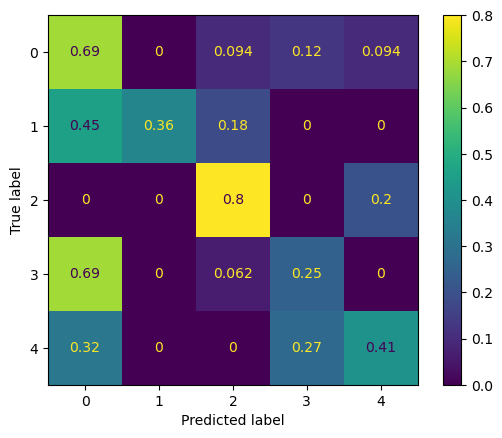

In [155]:
# Confusion matrix
cm = confusion_matrix(y_test, ensemble_pred, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Meta Learning with Weighted Average!

Based on classifier performance

https://machinelearningmastery.com/weighted-average-ensemble-with-python/

In [156]:
# get a list of base models
def get_models():
    models = list()
    models.append(('svm', SVC(random_state=rand_seed)))
    models.append(('lr', LogisticRegression(random_state=rand_seed, max_iter=1000)))
    models.append(('dt', DecisionTreeClassifier(random_state=rand_seed, max_depth=8)))
    models.append(('nb', GaussianNB()))
    models.append(('knn', KNeighborsClassifier(n_neighbors=5)))
    return models

# evaluate each base model
def evaluate_models(models, X_train, X_test, y_train, y_test):
    # fit and evaluate models
    scores = list()
    for name, model in models:
        # fit the classifiers
        model.fit(X_train, y_train)
        # eval model
        ypred = model.predict(X_test)
        f1_macro_score = f1_score(y_test, ypred, average="macro")
        # store performance
        scores.append(f1_macro_score)
    # report model performance
    return scores

# get the base models
models = get_models()
# fit and eval each model
scores = evaluate_models(models, X_train, X_test, y_train, y_test)
precision

# Create ensemble
voting_ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# Fit the ensemble to the training dataset
voting_ensemble_clf = voting_ensemble.fit(X_train, y_train)
voting_ensemble_pred = voting_ensemble_clf.predict(X_test)
# Evaluate predictions
score = f1_score(y_test, voting_ensemble_pred, average="macro")
print(f"Weighted Average F1 macro: {score*100}")

# Use cross validation for evaluation
cv_scores = cross_val_score(voting_ensemble_clf, X_train, y_train, cv=9,
    scoring="f1_macro")
avg_cv_scores = np.average(cv_scores)
std_cv_scores = np.std(cv_scores)
print(f"Voting Classifier with Weighted Average and 9-fold cv f1 macro avg: {avg_cv_scores:.4f}")
print(f"Voting Classifier with Weighted Average and 9-fold cv f1 macro std: {std_cv_scores:.4f}")

Weighted Average F1 macro: 46.764044016420506
Voting Classifier with Weighted Average and 9-fold cv f1 macro avg: 0.5828
Voting Classifier with Weighted Average and 9-fold cv f1 macro std: 0.0513


0.5697, k=5
0.5931, k=6
0.5619, k=7
0.5604, k=8
0.5788, k=9
0.5752, k=10


